# Probabilistic U-Net Training on the Moving MNIST dataset

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import datetime
import wandb
import torch
import models.probabilistic_unet as p_unet
import visualization as viz
from models import (
    MeanStdUNet,
    BinClassifierUNet,
    QuantileRegressorUNet,
    MonteCarloDropoutUNet,
)
import numpy as np
import random
from tqdm import tqdm


In [3]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)


In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"using device: {device}")


using device: cuda


# Quantile Regressor UNet

## Train model

In [6]:
INPUT_FRAMES = 3
FILTERS = 16
LEARNING_RATE = 1e-3
BATCH_SIZE = 32


In [9]:
qr_unet = QuantileRegressorUNet(
    # quantiles=[0.1, 0.5, 0.9],
    quantiles=list(np.linspace(0, 1, 7)[1:-1]),
    in_frames=INPUT_FRAMES,
    filters=FILTERS
)
qr_unet.model.to(device)
qr_unet.initialize_weights()
qr_unet.initialize_optimizer(method="SGD", lr=LEARNING_RATE)
qr_unet.create_dataloaders(
    path="../datasets/moving_mnist_dataset/",
    batch_size=BATCH_SIZE,
)


In [7]:
EPOCHS = 2
NUM_TRAIN_SAMPLES = 1000
PRINT_EVERY_N_BATCHES = 500
NUM_VAL_SAMPLES = 100
SAVE_EXPERIMENT = True


In [8]:
# start a new wandb run to track this script
if SAVE_EXPERIMENT:
    run = wandb.init(
        project="cloudiness_probabilistic_forecasting",
        name=datetime.datetime.now().strftime("%Y-%m-%d %H:%M"),
        config={
            "optimizer": "SGD",
            "learning_rate": LEARNING_RATE,
            "architecture": qr_unet.name,
            "dataset": "moving_mnist",
            "epochs": EPOCHS,
        },
    )

    wandb.watch(qr_unet.model, log_freq=100)
else:
    run = None

train_loss, val_loss = qr_unet.fit(
    n_epochs=EPOCHS,
    num_train_samples=NUM_TRAIN_SAMPLES,
    print_train_every_n_batch=PRINT_EVERY_N_BATCHES,
    num_val_samples=NUM_VAL_SAMPLES,
    device=device,
    run=run,
    model_name="qr_model_mmnist_test",
    checkpoint_path="../checkpoints/prueba/",
    verbose=True,
)

if SAVE_EXPERIMENT:
    wandb.finish()


wandb: Currently logged in as: andresherrera. Use `wandb login --relogin` to force relogin


BATCH(1/4250) | Train loss(1.2003) | Time Batch(10.23) | 
BATCH(501/4250) | Train loss(0.2947) | Time Batch(0.02) | 
BATCH(1001/4250) | Train loss(0.1625) | Time Batch(0.01) | 
Epoch(1/2) | Train_loss(0.4066) | Val_loss(0.1641) | CRPS(0.1641) | Time_Epoch(1210.31s) |
Saving best model. Best val loss: 0.1641
BATCH(1/4250) | Train loss(0.1642) | Time Batch(0.02) | 
BATCH(501/4250) | Train loss(0.1242) | Time Batch(0.01) | 
BATCH(1001/4250) | Train loss(0.1078) | Time Batch(0.01) | 
Epoch(2/2) | Train_loss(0.1298) | Val_loss(0.1096) | CRPS(0.1067) | Time_Epoch(656.81s) |
Saving best model. Best val loss: 0.1096


crps_quantile,█▁
train_loss,█▁
val_loss,█▁
crps_quantile,0.10673
train_loss,0.12976
val_loss,0.10963


## Visualize Trained model predictions

In [13]:
qr_unet.load_checkpoint(
    checkpoint_path="../checkpoints/prueba/qr_model_mmnist_test_002.pt",
    device=device
)


In [14]:
with torch.no_grad():
    for val_batch_idx, (in_frames, out_frames) in enumerate(
        qr_unet.val_loader
    ):
    
        in_frames = in_frames.to(device=device).float()
        print(f"input frames shape: {in_frames.shape}")
        out_frames = out_frames.to(device=device)
        print(f"output frame shape: {out_frames.shape}")
    
        frames_pred = qr_unet.predict(in_frames)
        print(f"prediction shape: {frames_pred.shape}")
        break


input frames shape: torch.Size([32, 3, 64, 64])
output frame shape: torch.Size([32, 1, 64, 64])
prediction shape: torch.Size([32, 5, 64, 64])


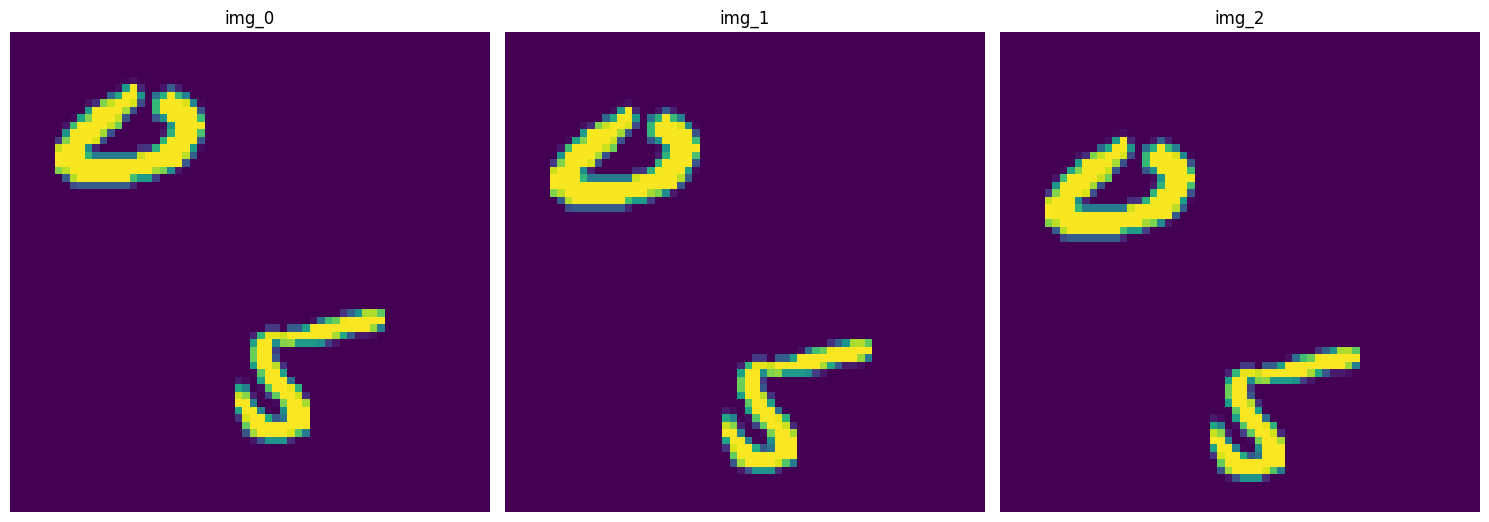

In [22]:
viz.show_image_list(
    in_frames[0].cpu().tolist(),
    show_fig=True,
)


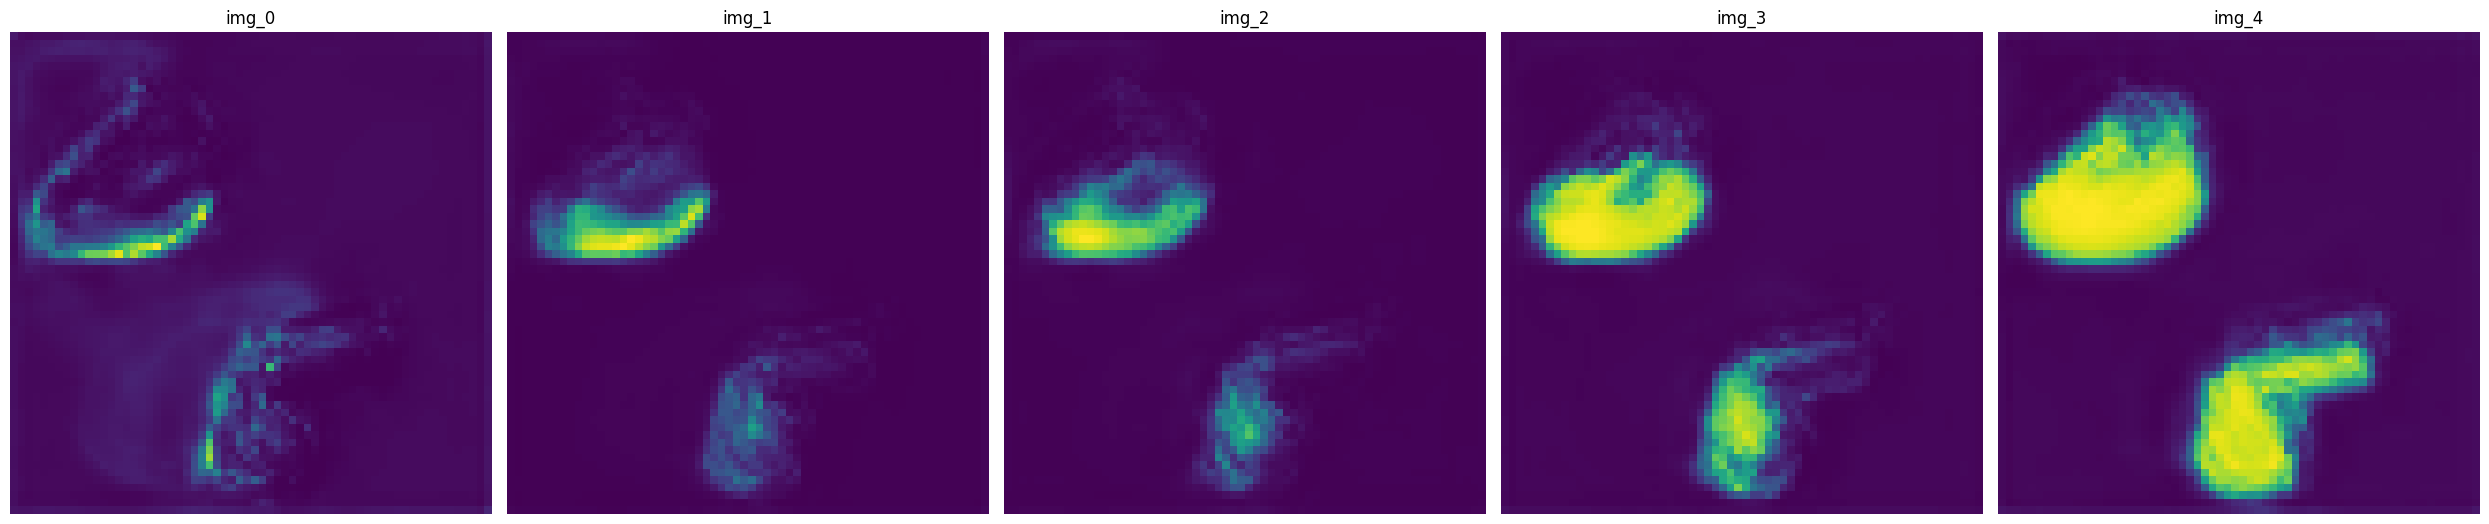

In [23]:
viz.show_image_list(
    frames_pred[0].cpu().tolist(),
    show_fig=True,
)

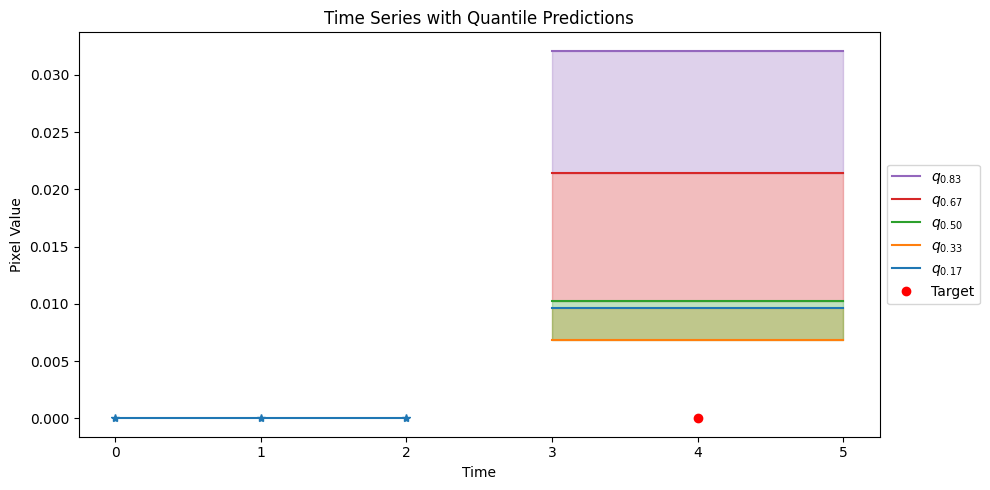

In [18]:
viz.plot_quantile_predictions(
    input_images=in_frames[0],
    pred_quantiles=frames_pred[0],
    quantiles=qr_unet.quantiles,
    target_img=out_frames[0],
    pixel_coords=(32, 32),
    fig_name=None,
    width=3,
)


In [ ]:
rompe

# Bin Classifier UNet

## Train model

In [10]:
INPUT_FRAMES = 3
FILTERS = 16
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
NUM_BINS = 5


In [15]:
bin_unet = BinClassifierUNet(
    n_bins=NUM_BINS,
    in_frames=INPUT_FRAMES,
    filters=FILTERS,
    device=device,
)
bin_unet.model.to(device)
bin_unet.initialize_weights()
bin_unet.initialize_optimizer(method="SGD", lr=LEARNING_RATE)
bin_unet.create_dataloaders(
    path="../datasets/moving_mnist_dataset/",
    batch_size=BATCH_SIZE,
    binarization_method="integer_classes",
)


In [16]:
EPOCHS = 2
NUM_TRAIN_SAMPLES = 1000
PRINT_EVERY_N_BATCHES = 500
NUM_VAL_SAMPLES = 100
SAVE_EXPERIMENT = True


In [17]:
# start a new wandb run to track this script
if SAVE_EXPERIMENT:
    run = wandb.init(
        project="cloudiness_probabilistic_forecasting",
        name=datetime.datetime.now().strftime("%Y-%m-%d %H:%M"),
        config={
            "optimizer": "SGD",
            "learning_rate": LEARNING_RATE,
            "architecture": bin_unet.name,
            "dataset": "moving_mnist",
            "epochs": EPOCHS,
        },
    )

    wandb.watch(bin_unet.model, log_freq=100)
else:
    run = None

train_loss, val_loss = bin_unet.fit(
    n_epochs=EPOCHS,
    num_train_samples=NUM_TRAIN_SAMPLES,
    print_train_every_n_batch=PRINT_EVERY_N_BATCHES,
    num_val_samples=NUM_VAL_SAMPLES,
    device=device,
    run=run,
    model_name="bin_model_mmnist_test",
    checkpoint_path="../checkpoints/prueba/",
    verbose=True,
)

if SAVE_EXPERIMENT:
    wandb.finish()


BATCH(1/4250) | Train loss(1.5669) | Time Batch(0.02) | 
BATCH(501/4250) | Train loss(1.1977) | Time Batch(0.01) | 
BATCH(1001/4250) | Train loss(1.0766) | Time Batch(0.01) | 
Epoch(1/2) | Train_loss(1.2313) | Val_loss(1.0770) | CRPS(0.3598 | precision(0.2443 | Time_Epoch(269.28s) |
Saving best model. Best val loss: 1.0770
BATCH(1/4250) | Train loss(1.0800) | Time Batch(0.01) | 
BATCH(501/4250) | Train loss(1.0222) | Time Batch(0.01) | 
BATCH(1001/4250) | Train loss(0.9975) | Time Batch(0.01) | 
Epoch(2/2) | Train_loss(1.0283) | Val_loss(0.9982) | CRPS(0.1124 | precision(0.1884 | Time_Epoch(196.64s) |
Saving best model. Best val loss: 0.9982


crps_bin,█▁
precision,█▁
train_loss,█▁
val_loss,█▁
crps_bin,0.11244
precision,0.18838
train_loss,1.02833
val_loss,0.9982


In [ ]:
rompe


# Mean-Std UNet

## Train model

In [5]:
INPUT_FRAMES = 3
FILTERS = 16
LEARNING_RATE = 1e-3
BATCH_SIZE = 32


In [6]:
meanstd_unet = MeanStdUNet(
    in_frames=INPUT_FRAMES,
    filters=FILTERS
)

meanstd_unet.model.to(device)
meanstd_unet.initialize_weights()
meanstd_unet.initialize_optimizer(method="SGD", lr=LEARNING_RATE)
meanstd_unet.create_dataloaders(
    path="../datasets/moving_mnist_dataset/",
    batch_size=BATCH_SIZE,
)


In [7]:
EPOCHS = 2
NUM_TRAIN_SAMPLES = 1
PRINT_EVERY_N_BATCHES = 500
NUM_VAL_SAMPLES = 1
SAVE_EXPERIMENT = False


In [12]:
# start a new wandb run to track this script
if SAVE_EXPERIMENT:
    run = wandb.init(
        project="cloudiness_probabilistic_forecasting",
        name=datetime.datetime.now().strftime("%Y-%m-%d %H:%M"),
        config={
            "optimizer": "SGD",
            "learning_rate": LEARNING_RATE,
            "architecture": meanstd_unet.name,
            "dataset": "moving_mnist",
            "epochs": EPOCHS,
        },
    )

    wandb.watch(meanstd_unet.model, log_freq=100)
else:
    run = None

train_loss, val_loss = meanstd_unet.fit(
    n_epochs=EPOCHS,
    num_train_samples=NUM_TRAIN_SAMPLES,
    print_train_every_n_batch=PRINT_EVERY_N_BATCHES,
    num_val_samples=NUM_VAL_SAMPLES,
    device=device,
    run=run,
    model_name="meanstd_model_mmnist_test",
    checkpoint_path="../checkpoints/prueba/",
    verbose=True,
)

if SAVE_EXPERIMENT:
    wandb.finish()


INFO:MeanStdUNet:BATCH(1/4250) | Train loss(1.0626) | Time Batch(0.03) | 
INFO:MeanStdUNet:Epoch(1/2) | Train_loss(1.0621) | Val_loss(1.0444) | MAE(0.5091) | CRPS(0.3082 | Time_Epoch(9.25s) |
INFO:MeanStdUNet:Saving best model. Best val loss: 1.0444
INFO:MeanStdUNet:BATCH(1/4250) | Train loss(1.0611) | Time Batch(0.16) | 
INFO:MeanStdUNet:Epoch(2/2) | Train_loss(1.0603) | Val_loss(1.0435) | MAE(0.5085) | CRPS(0.3082 | Time_Epoch(8.70s) |
INFO:MeanStdUNet:Saving best model. Best val loss: 1.0435


## Train all models

In [9]:
rompe

NameError: name 'rompe' is not defined

In [ ]:
NUM_BINS = 10
INPUT_FRAMES = 3
EPOCHS = 5
NUM_TRAIN_SAMPLES = 1
PRINT_EVERY_N_BATCHES = 500
NUM_VAL_SAMPLES = 1
BATCH_SIZE = 32
FILTERS = 16
LEARNING_RATE = 1e-3
ENSEMBLE_PREDICTIONS = 1
SAVE_EXPERIMENT = False


In [ ]:
for cls in map(p_unet.__dict__.get, p_unet.__all__):
    if cls.__name__ == MeanStdUNet.__name__:
        continue
        print("=" * 3, "MeanStdUNet", "=" * 3)
        probabilistic_unet = cls(in_frames=INPUT_FRAMES, filters=FILTERS)
    elif cls.__name__ == BinClassifierUNet.__name__:
        continue
        print("=" * 3, "BinClassifierUNet", "=" * 3)
        probabilistic_unet = cls(
            n_bins=NUM_BINS, in_frames=INPUT_FRAMES, filters=FILTERS
        )
    elif cls.__name__ == QuantileRegressorUNet.__name__:
        print("=" * 3, "QuantileRegressorUNet", "=" * 3)
        probabilistic_unet = cls(
            quantiles=[0.1, 0.5, 0.9], in_frames=INPUT_FRAMES, filters=FILTERS
        )
    elif cls.__name__ == MonteCarloDropoutUNet.__name__:
        continue
        print("=" * 3, "MonteCarloDropoutUNet", "=" * 3)
        probabilistic_unet = cls(
            dropout_p=0.5, in_frames=INPUT_FRAMES, filters=FILTERS
        )
        ENSEMBLE_PREDICTIONS = 3
    else:
        print("Wrong class type!")

    probabilistic_unet.model.to(device)
    probabilistic_unet.initialize_weights()
    probabilistic_unet.initialize_optimizer(method="SGD", lr=LEARNING_RATE)
    probabilistic_unet.create_dataloaders(
        path="../datasets/moving_mnist_dataset/",
        batch_size=BATCH_SIZE,
        binarization_method="integer_classes",  # needed for BinClassifierUNet
    )

    # start a new wandb run to track this script
    if SAVE_EXPERIMENT:
        run = wandb.init(
            project="cloudiness_probabilistic_forecasting",
            name=datetime.datetime.now().strftime("%Y-%m-%d %H:%M"),
            config={
                "optimizer": "SGD",
                "learning_rate": LEARNING_RATE,
                "architecture": probabilistic_unet.name,
                "dataset": "moving_mnist",
                "epochs": EPOCHS,
            },
        )

        wandb.watch(probabilistic_unet.model, log_freq=100)
    else:
        run = None

    train_loss, val_loss = probabilistic_unet.fit(
        n_epochs=EPOCHS,
        num_train_samples=NUM_TRAIN_SAMPLES,
        print_train_every_n_batch=PRINT_EVERY_N_BATCHES,
        num_val_samples=NUM_VAL_SAMPLES,
        device=device,
        run=run,
        verbose=True,
        ensemble_predictions=ENSEMBLE_PREDICTIONS,
    )

    if SAVE_EXPERIMENT:
        wandb.finish()